# Exploratory data analysis

In [49]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from holidays import country_holidays
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

In [2]:
TRAIN_DATA_PATH = '../data/df.csv'
RANDOM_STATE = 123

In [3]:
# freeze random state for reproducibility

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
pl.set_random_seed(RANDOM_STATE)

In [4]:
# index feature is unique among all data, so we can skip it

data = pl.read_csv(
    TRAIN_DATA_PATH, 
    columns=['date', 'category_id', 'sku_id', 'sales_price', 'sales_quantity']
)
data.head()

date,category_id,sku_id,sales_price,sales_quantity
str,i64,i64,f64,f64
"""2016-11-25""",7,1108,457.6,1.0
"""2016-11-18""",7,2999,470.6,1.0
"""2016-11-18""",7,1428,717.6,1.0
"""2016-11-18""",7,3923,383.5,1.0
"""2016-11-18""",17,8075,18.85,2.0


## Data exploration & preprocessing

In [5]:
data = data.with_columns(
    pl.col('date').str.to_date()
)

In [6]:
# let's start with some basic statistics

data.describe()

statistic,date,category_id,sku_id,sales_price,sales_quantity
str,str,f64,f64,f64,f64
"""count""","""226486""",226486.0,226486.0,226486.0,226486.0
"""null_count""","""0""",0.0,0.0,0.0,0.0
"""mean""","""2018-12-30""",15.069594,497813.898607,109.033102,16.078857
"""std""",null,4.625731,242446.818578,151.500911,184.248121
"""min""","""2016-11-18""",7.0,1045.0,1.027,1.0
"""25%""","""2018-01-12""",17.0,398064.0,38.22,1.0
"""50%""","""2019-01-09""",17.0,550996.0,51.35,3.0
"""75%""","""2020-01-12""",17.0,702116.0,71.5,5.0
"""max""","""2020-10-31""",23.0,838924.0,2923.7,8069.0


In [7]:
data.select(
    pl.col(col).is_null().sum().alias(f'{col}_null_count')
    for col in data.columns
)

date_null_count,category_id_null_count,sku_id_null_count,sales_price_null_count,sales_quantity_null_count
u32,u32,u32,u32,u32
0,0,0,0,0


In [8]:
for col in data.columns:
    print(f'Column {col} has {len(data[col].unique())} unique values')

Column date has 1420 unique values
Column category_id has 3 unique values
Column sku_id has 1059 unique values
Column sales_price has 1373 unique values
Column sales_quantity has 979 unique values


Firstly, let's extract some simple date features from date column

In [50]:
ua_holidays = country_holidays('UA')


In [54]:
data = data.with_columns(
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.month().alias('month'),
    pl.col('date').dt.day().alias('day'),
    pl.col('date').dt.week().alias('week'),
    pl.col('date').dt.weekday().alias('weekday'),
    pl.col('date').dt.quarter().alias('quarter'),
    pl.col('date').dt.ordinal_day().alias('day_of_year'),
    
    # add is_weekend and is_ukrainian_holiday features, because it is quite probable that on these days people would buy more
    # possibly we can merge them into one feature in the next 
    ((pl.col('date').dt.weekday() >= 5)).alias('is_weekend'),
    pl.col('date').map_elements(lambda x: x in ua_holidays, return_dtype=pl.Boolean).alias('is_ukrainian_holiday')
)

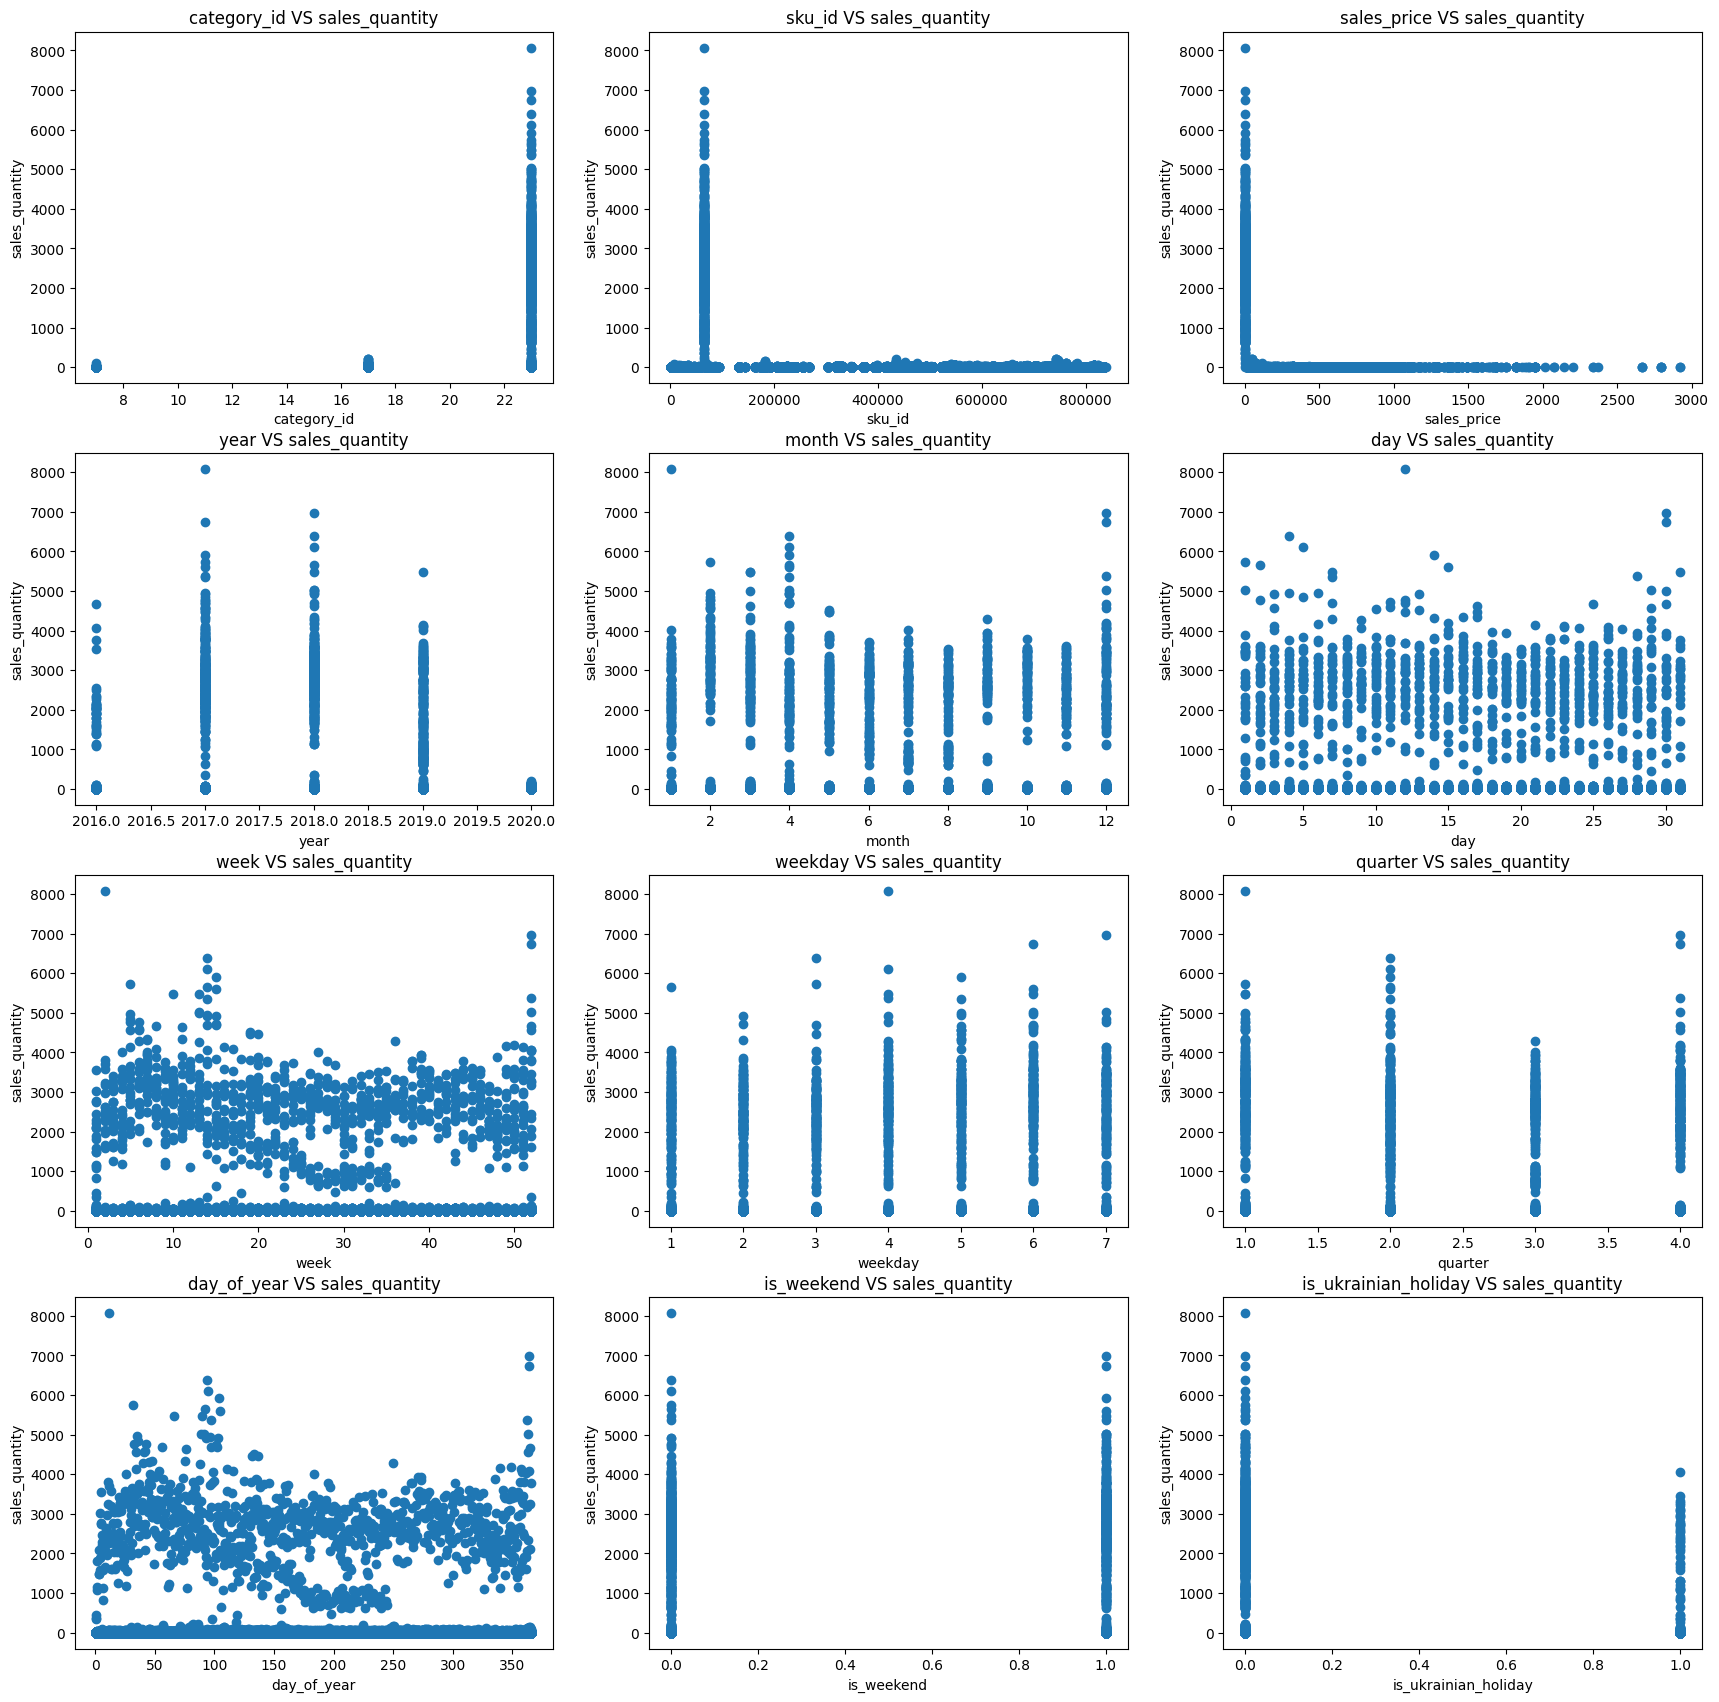

In [55]:
# let's plot all features VS target variable (sales_quantity)

plot_data = data.drop('sales_quantity', 'date')
rows = int(np.ceil(np.sqrt(len(plot_data.columns))))
cols = int(np.ceil(len(plot_data.columns) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(21, 21))
for col, ax in zip(plot_data.columns, axs.flatten()):
    ax.scatter(plot_data[col], data['sales_quantity'])
    ax.set_xlabel(col)
    ax.set_ylabel('sales_quantity')
    ax.set_title(f'{col} VS sales_quantity')
plt.show()

- from the above plot we can see that on holidays people usually buy less than on weekdays
- there is an interesting relashionship between sales_price and sales_quantity, same for sku_id and sales_quantity
- category “23” is bought much more than other categories (TODO: needs to be validated, see fraction of categories in dataset)

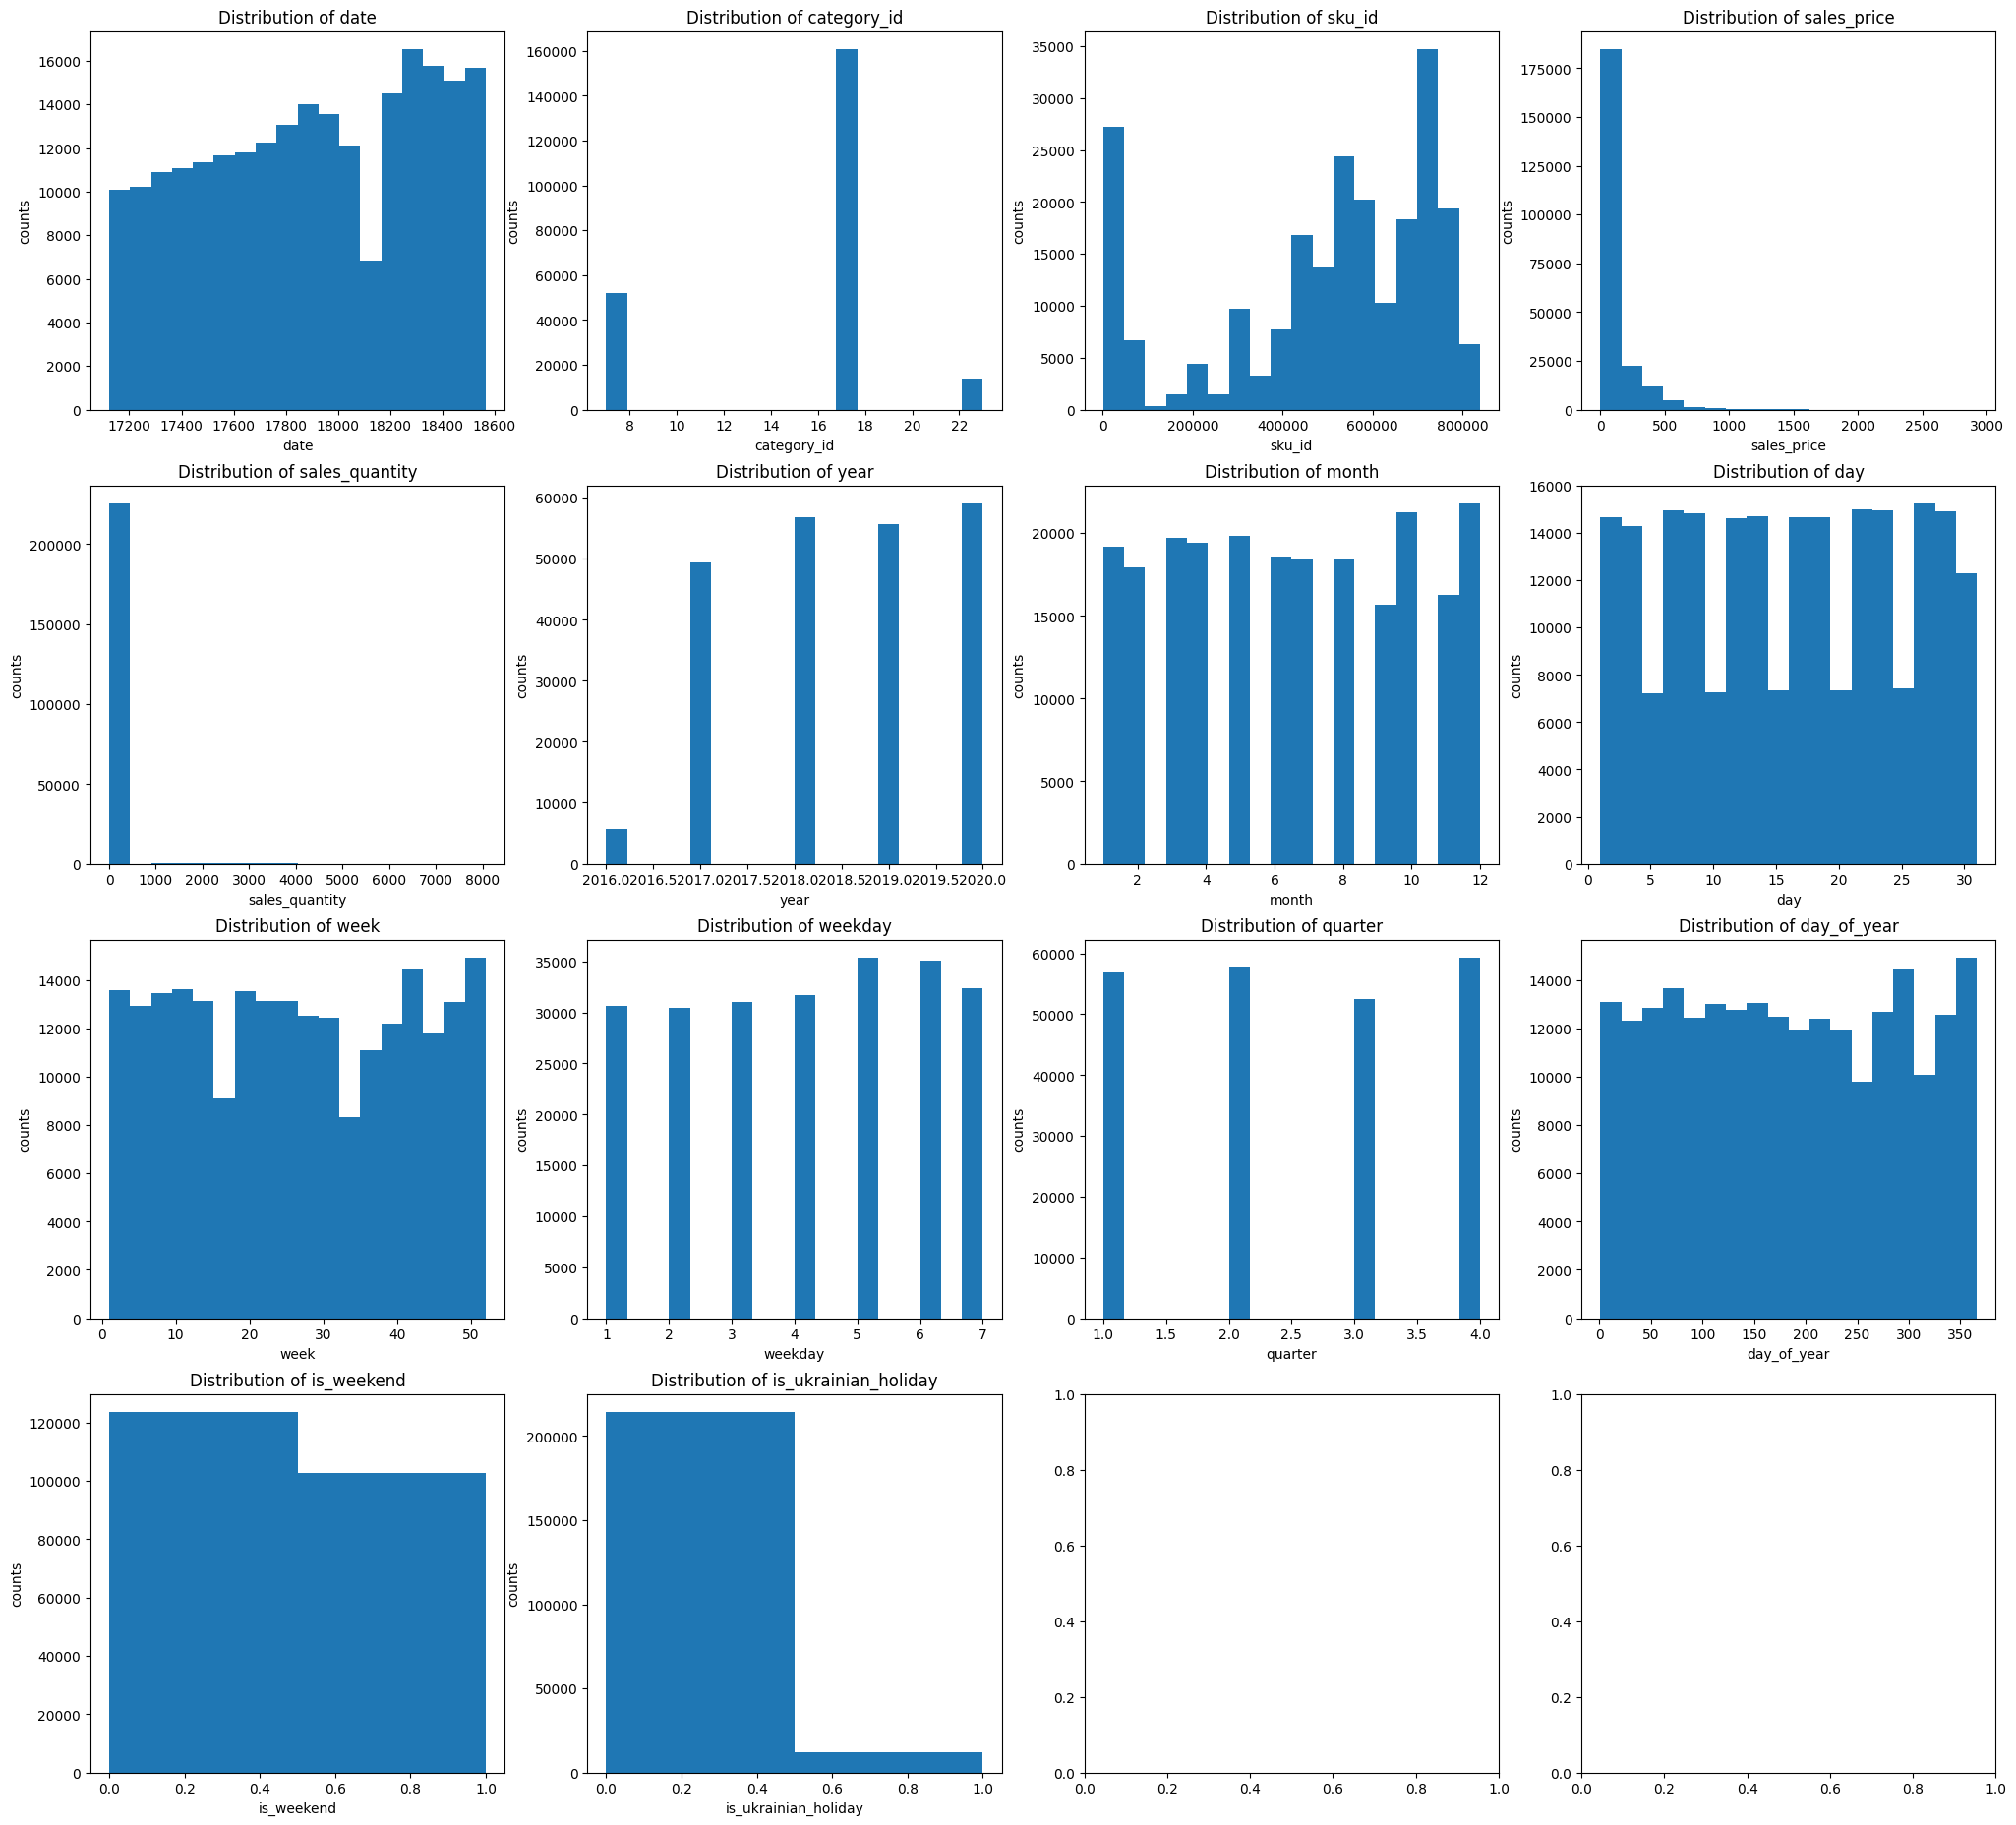

In [56]:
# let's also see each column distribution closely

rows = int(np.ceil(np.sqrt(len(data.columns))))
cols = int(np.ceil(len(data.columns) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(25, 23))
for col, ax in zip(data.columns, axs.flatten()):
    tdata = data[col].cast(pl.Int64)
    is_boolean = len(tdata.unique()) == 2
    ax.hist(tdata, bins= 2 if is_boolean else int(np.log2(len(tdata))+1))
    ax.set_xlabel(col)
    ax.set_ylabel('counts')
    ax.set_title(f'Distribution of {col}')
plt.show()

- from the above graph and category_id distribution, we can see that fraction of "23" category is not high, so we can conclude that **category “23” is bought much more than other categories**

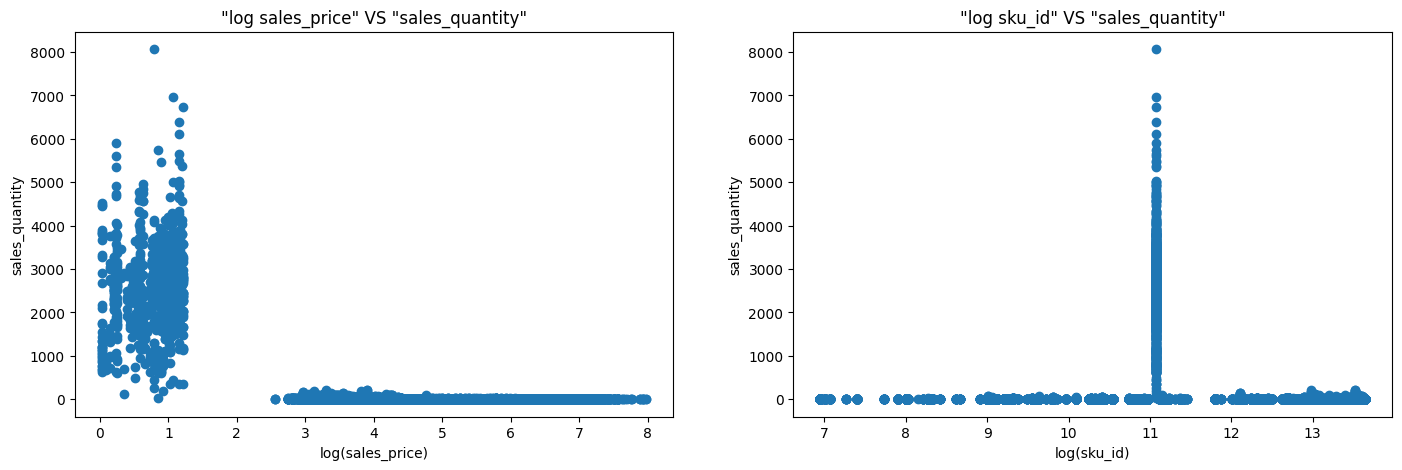

In [57]:
# from the above scatter plots we can also see that there is interesting relationship between sales_price and sales_quantity
# the same is also true for sku_id and sales_quantity
# let's try to plot log-scaled features to see whether there is more clear correlation

fig, axs = plt.subplots(1, 2, figsize=(17, 5))
axs[0].scatter(np.log(data['sales_price']), data['sales_quantity'])
axs[1].scatter(np.log(data['sku_id']), data['sales_quantity'])

axs[0].set_title('"log sales_price" VS "sales_quantity"')
axs[0].set_xlabel('log(sales_price)')
axs[0].set_ylabel('sales_quantity')
axs[1].set_title('"log sku_id" VS "sales_quantity"')
axs[1].set_xlabel('log(sku_id)')
axs[1].set_ylabel('sales_quantity')

plt.show()

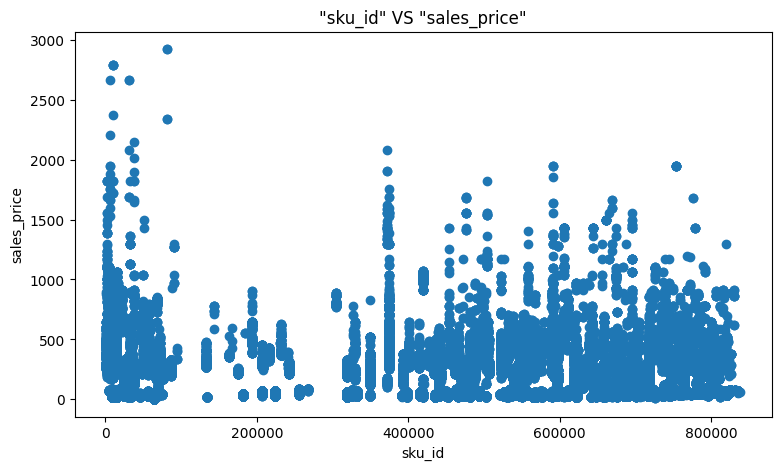

In [58]:
plt.figure(figsize=(9, 5))
plt.scatter(data['sku_id'], data['sales_price'])
plt.title('"sku_id" VS "sales_price"')
plt.xlabel('sku_id')
plt.ylabel('sales_price')
plt.show()

- As we can see, log-scaled plot shows that sales_quantity accualy has some correlation with sales_price
- Also we can see that there is possible dependency of sales_price on sku_id

In [59]:
def corr_plot(data: pl.DataFrame, exclude_features: list[str]) -> None:
    plt.figure(figsize=(13, 13))
    corr_df = data.drop(*exclude_features).corr()
    pandas_df = corr_df.to_pandas()
    pandas_df.insert(0, 'index', pandas_df.columns)
    pandas_df = pandas_df.set_index('index')
    pandas_df.index.name = None
    sns.heatmap(pandas_df, annot=True, fmt='.3f', cmap='crest')
    plt.title('Correlation plot of dataset features')
    plt.show()

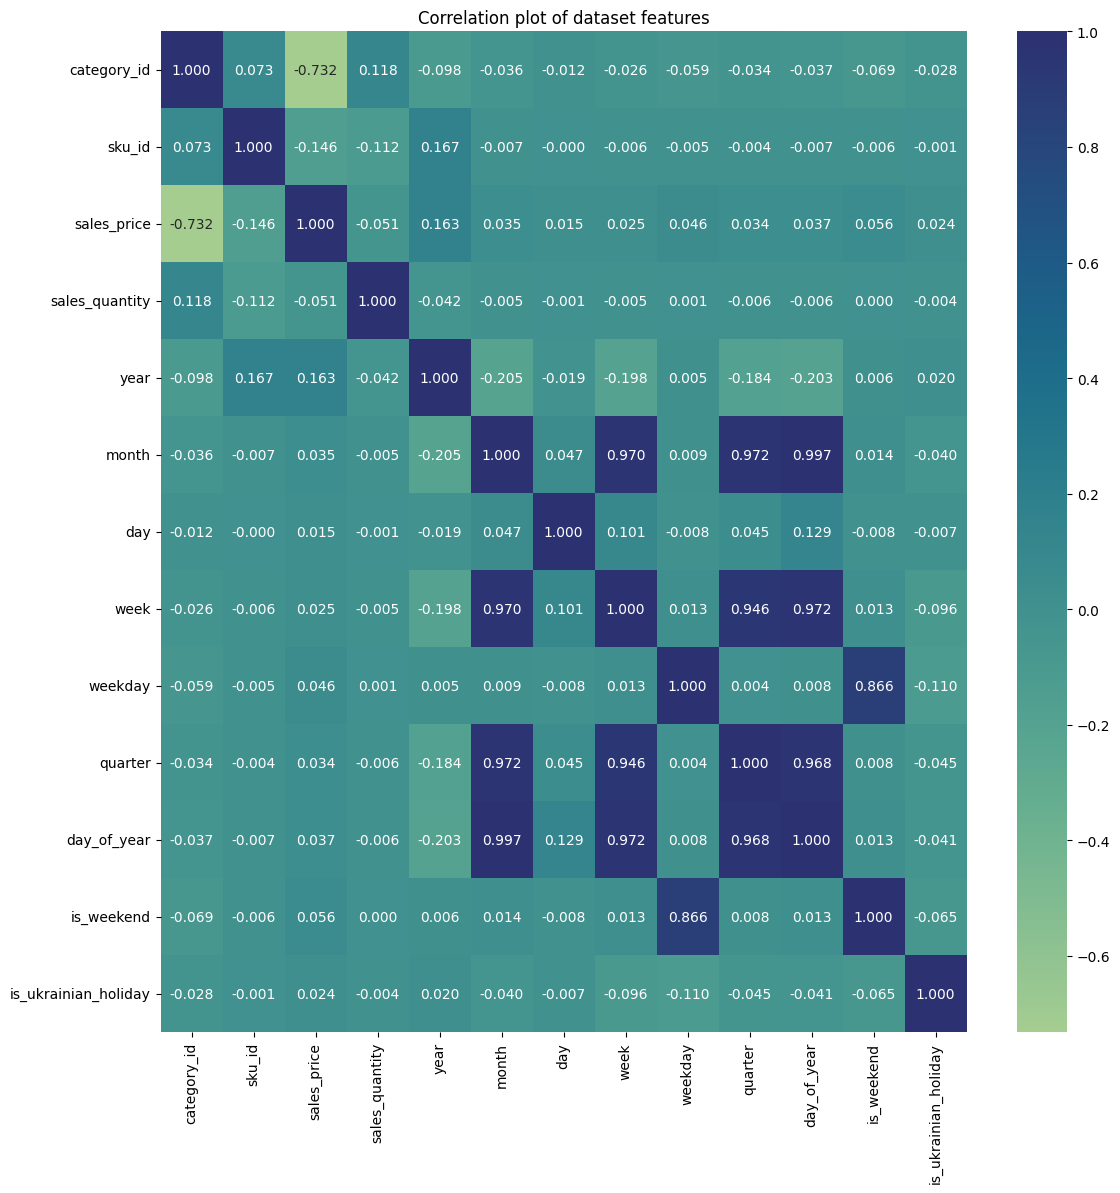

In [60]:
corr_plot(data, exclude_features=['date'])

- From this corr plot we can see, that there are now some multicollinearity between engineered date features. This can affect model's performance, so we need to remove redundunt date features
- Also we can see that category_id and sales_price from original data are quite high-correlated too

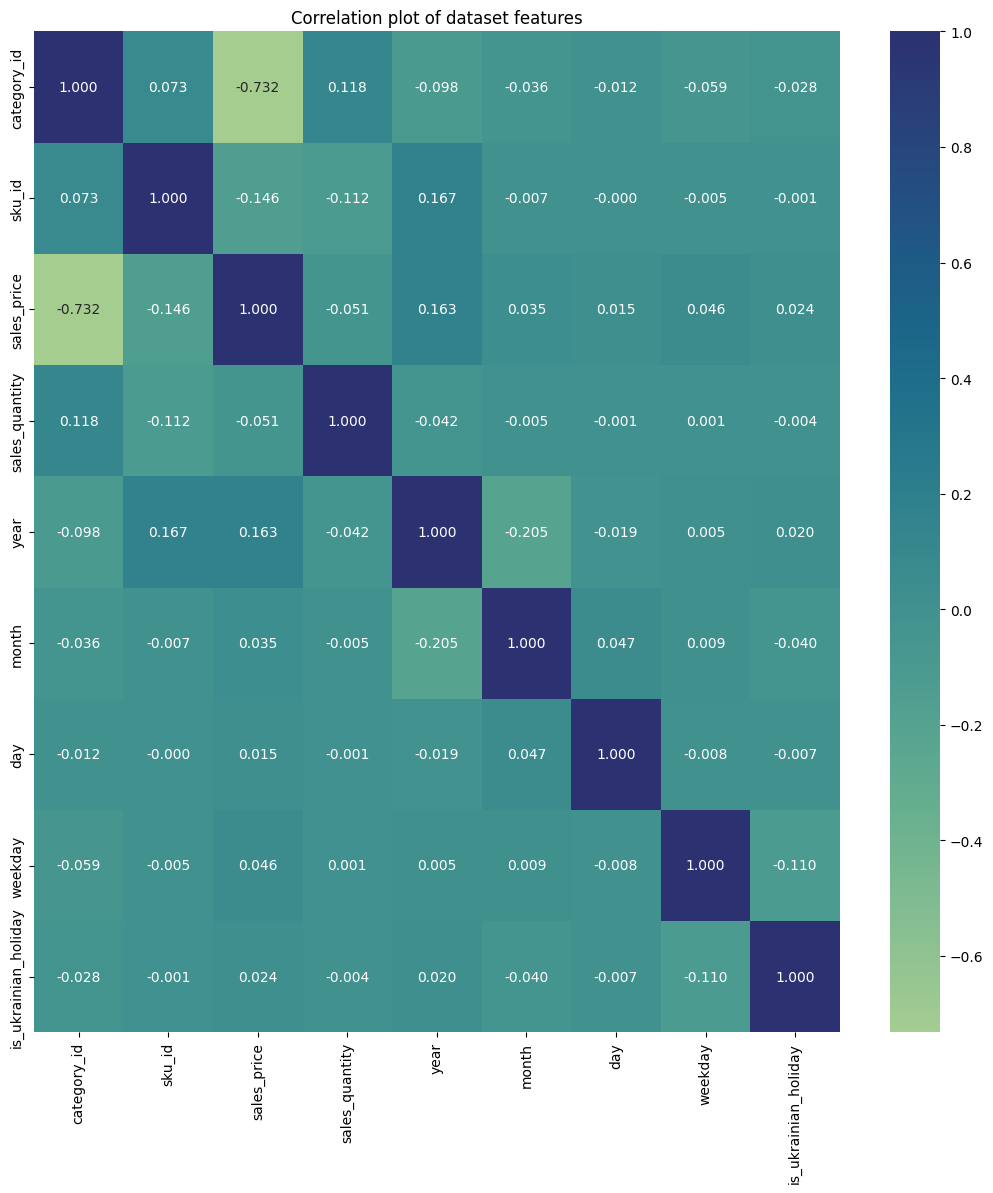

In [61]:
# I tried to play with removing different features, that is the best result
# I removed those, which are correlated with the lots of other features
# TODO: try model training with all these features, maybe the results would be better without removing them
corr_plot(data, exclude_features=['date', 'day_of_year', 'week', 'quarter', 'is_weekend'])

### Historical sales 

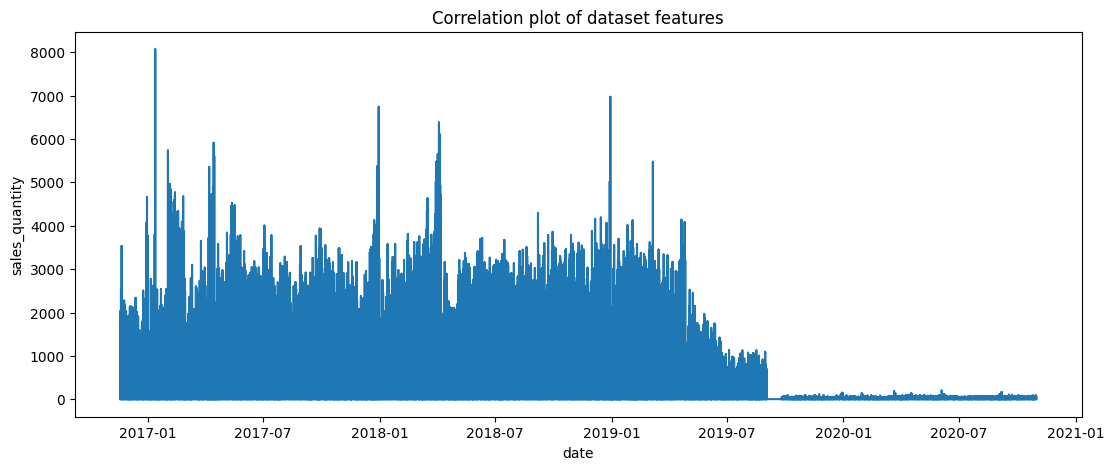

In [62]:
plt.figure(figsize=(13, 5))
tdata = data.sort(by='date')
plt.plot(tdata['date'], tdata['sales_quantity'])
plt.title('Correlation plot of dataset features')
plt.xlabel('date')
plt.ylabel('sales_quantity')
plt.show()

We can see that for some reason, the amount of sales dropped in autumn 2019. Maybe, it is somehow connected with covid because people started to buy more online. Or maybe there are simply less recent year data in the dataset. TODO: identify the real reason. 

#### Explore categories

In [63]:
categories = data['category_id'].unique().to_list()
categories

[7, 17, 23]

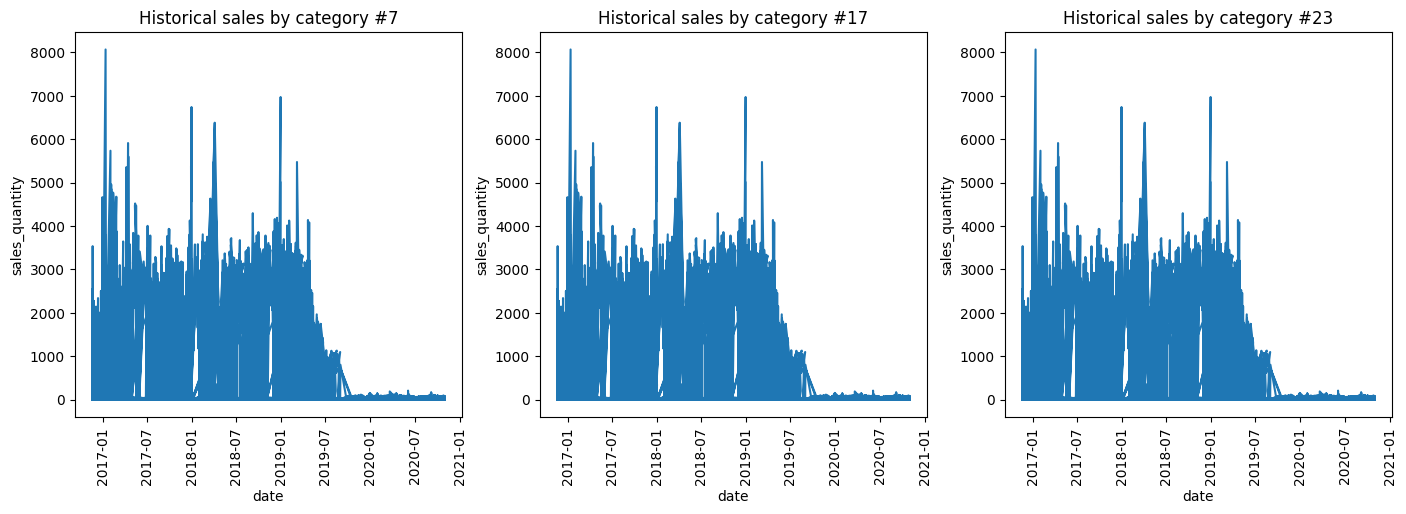

In [64]:
# let's also display historical sales by category

fig, axs = plt.subplots(ncols=len(categories), figsize=(17, 5))

for category, ax in zip(categories, axs):
    category_data = data.filter(pl.col('category_id') == category).sort(by='date')
    ax.plot(data['date'], data['sales_quantity'])
    ax.set_xlabel('date')
    ax.set_ylabel('sales_quantity')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f'Historical sales by category #{category}')

plt.show()

In [65]:
tdata = data['category_id'].value_counts(sort=True)
tdata.with_columns(
    (pl.col('count') / tdata['count'].sum()).alias('proportion')
)

category_id,count,proportion
i64,u32,f64
17,160797,0.709964
7,51959,0.229414
23,13730,0.060622


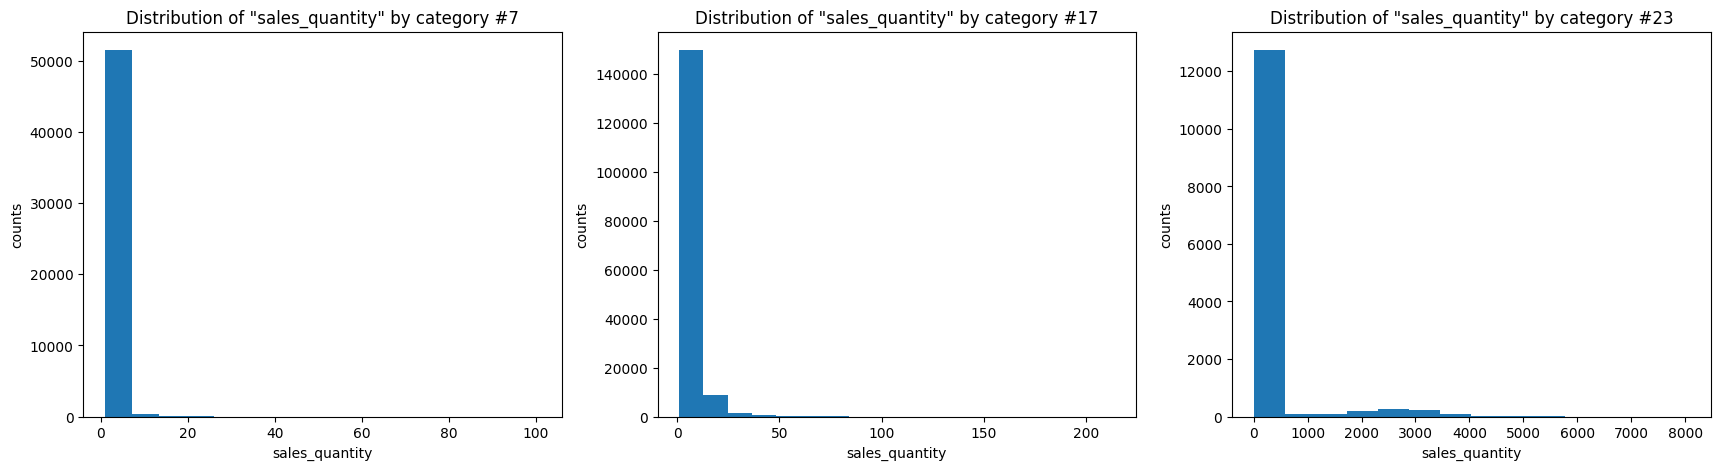

In [66]:
fig, axs = plt.subplots(ncols=len(categories), figsize=(21, 5))

for category, ax in zip(categories, axs):
    category_data = data.filter(pl.col('category_id') == category)
    ax.hist(category_data['sales_quantity'], bins=int(np.log2(len(category_data))+1))
    ax.set_xlabel('sales_quantity')
    ax.set_ylabel('counts')
    ax.set_title(f'Distribution of "sales_quantity" by category #{category}')

plt.show()

From all these graphs we can conclude that sales_quantity is not very good separable by category_id (distributions and historical sales look like more or less the same)

#### Let's try to get insights from exploring sku_id more closely

In [67]:
skus = data['sku_id'].unique().to_list()
len(skus)

1059

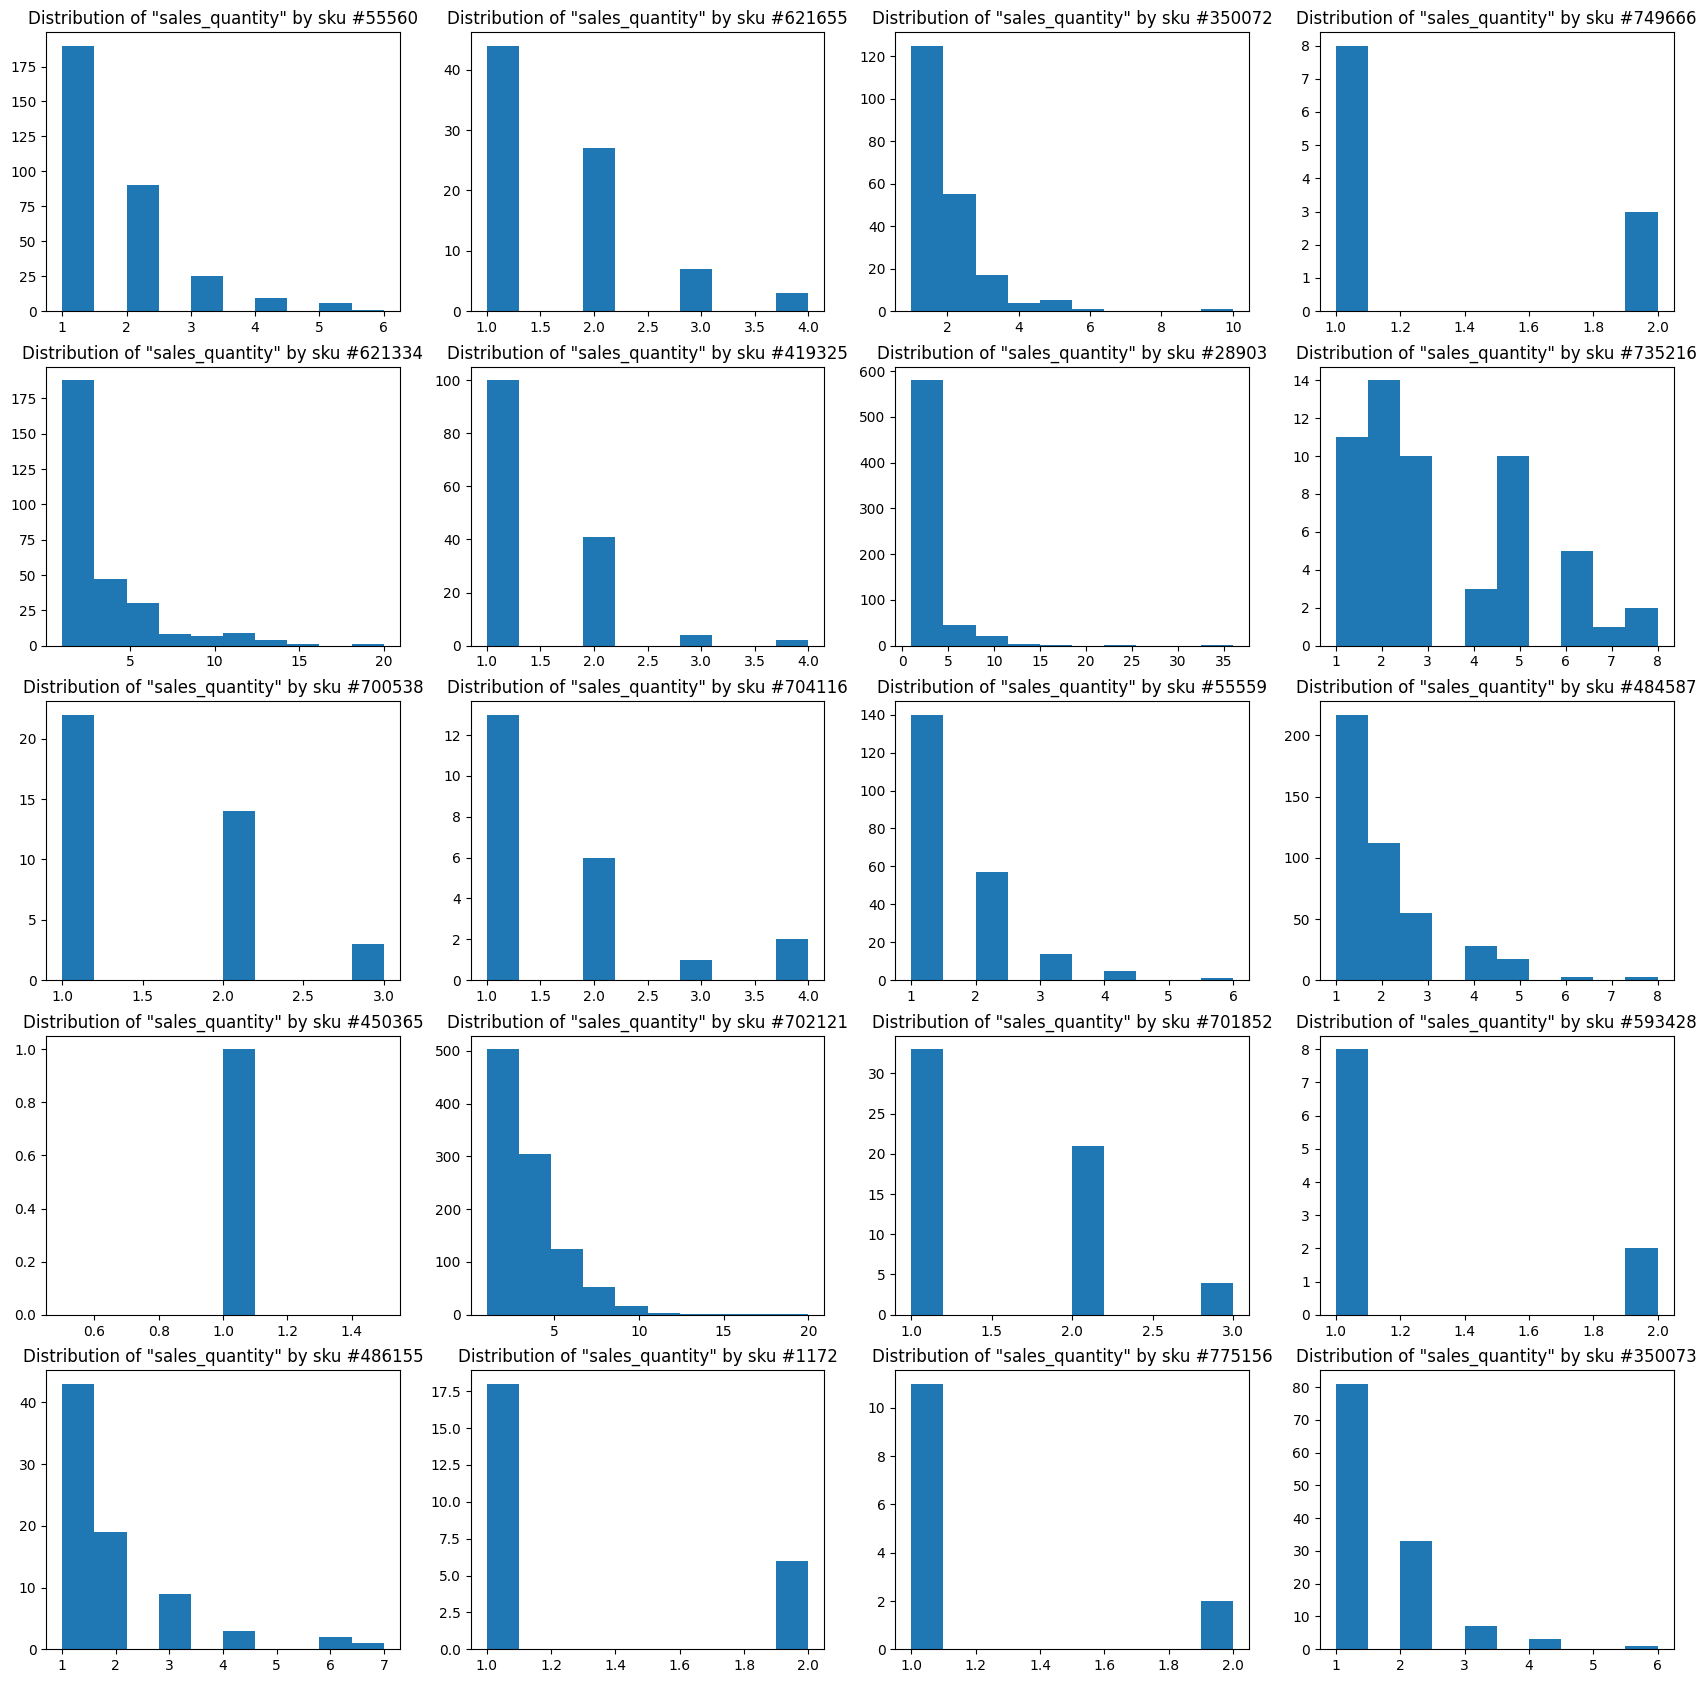

In [68]:
# let's visualize sales_quantity distributions by some random (15) sku_ids

tskus = random.sample(skus, 20)

rows = int(np.ceil(np.sqrt(len(tskus))))
cols = int(np.ceil(len(tskus) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(21, 21))

for sku, ax in zip(tskus, axs.flatten()):
    sku_data = data.filter(pl.col('sku_id') == sku)
    ax.hist(sku_data['sales_quantity'], bins=10)
    ax.set_title(f'Distribution of "sales_quantity" by sku #{sku}')

plt.show()

In [69]:
tdata = data['sku_id'].value_counts(sort=True)
tdata = tdata.with_columns(
    (pl.col('count') / tdata['count'].sum()).alias('proportion')
)
tdata.head(n=10)

sku_id,count,proportion
i64,u32,f64
18098,1416,0.006252
33412,1414,0.006243
8220,1409,0.006221
440333,1406,0.006208
663873,1394,0.006155
493549,1392,0.006146
589894,1391,0.006142
325774,1389,0.006133
548208,1380,0.006093


In [70]:
tdata.tail(n=10)

sku_id,count,proportion
i64,u32,f64
714240,1,0.000004
687871,1,0.000004
781456,1,0.000004
480896,1,0.000004
818719,1,0.000004
824358,1,0.000004
824357,1,0.000004
838924,1,0.000004
824359,1,0.000004


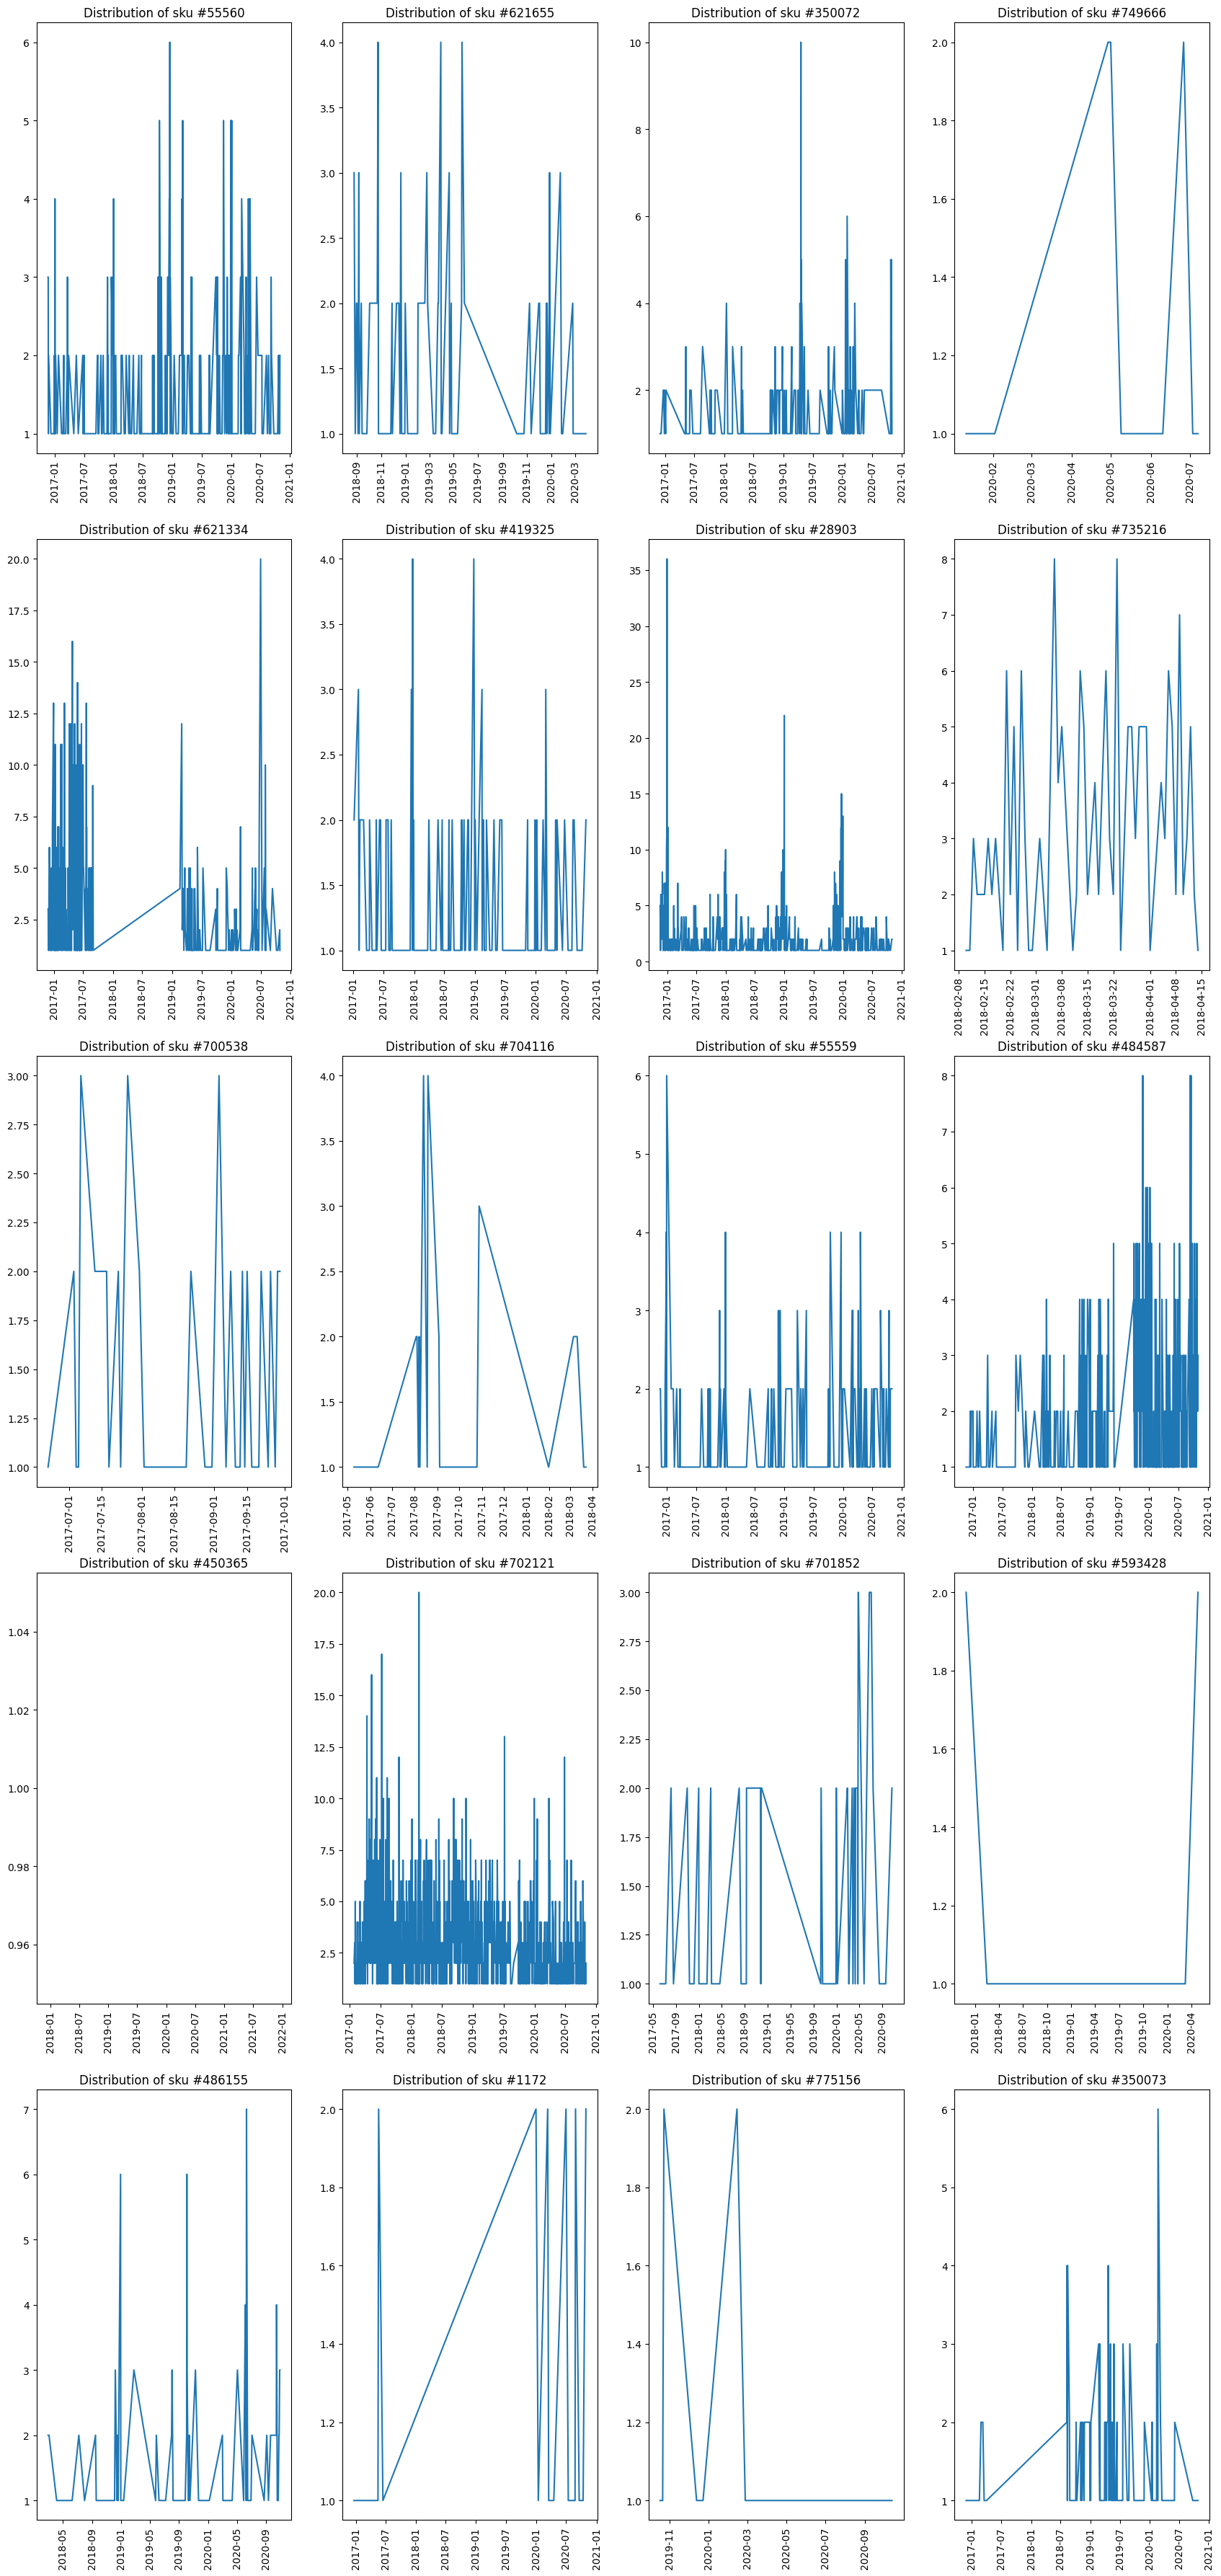

In [71]:
# also let's display some historical sales by sku

rows = int(np.ceil(np.sqrt(len(tskus))))
cols = int(np.ceil(len(tskus) / rows))
fig, axs = plt.subplots(rows, cols, figsize=(21, 45))

for sku, ax in zip(tskus, axs.flatten()):
    sku_data = data.filter(pl.col('sku_id') == sku).sort(by='date')
    ax.plot(sku_data['date'], sku_data['sales_quantity'])
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f'Distribution of sku #{sku}')

plt.show()

From above graphs we can see, that there is some identical patterns within differen sku_ids, so it is possible to cluster them into several similar clusters to include make different sku's products "share" information between each

### Time series feature engineering

But firstly, let's create some aggregating time series features like lags, indicators (sma), etc

In [72]:
tdata = data.drop('day_of_year', 'week', 'quarter', 'is_weekend')
tdata

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday
date,i64,i64,f64,f64,i32,i8,i8,i8,bool
2016-11-25,7,1108,457.6,1.0,2016,11,25,5,false
2016-11-18,7,2999,470.6,1.0,2016,11,18,5,false
2016-11-18,7,1428,717.6,1.0,2016,11,18,5,false
2016-11-18,7,3923,383.5,1.0,2016,11,18,5,false
2016-11-18,17,8075,18.85,2.0,2016,11,18,5,false
…,…,…,…,…,…,…,…,…,…
2020-10-14,7,21442,570.7,1.0,2020,10,14,3,true
2020-10-14,7,502340,505.7,3.0,2020,10,14,3,true
2020-10-14,7,723588,401.7,3.0,2020,10,14,3,true


In [73]:
# let's create separate lags for each sku_id, which seems to be a natural and logical step

NUM_LAGS = 3

lag_agg_sku_id = tdata.group_by(['sku_id', 'date']).agg(
    pl.col('sales_price').mean(),
    pl.col('sales_quantity').sum()
).sort(by=['sku_id', 'date'])

cols_sales_price = [pl.col('sales_price').shift(lag).alias(f'lag_{lag}_sales_price') for lag in range(1, NUM_LAGS+1)]
cols_sales_quantity = [pl.col('sales_quantity').shift(lag).alias(f'lag_{lag}_sales_quantity') for lag in range(1, NUM_LAGS+1)]
aggs = cols_sales_price + cols_sales_quantity
aggs.insert(0, pl.col('date'))
lag_agg_sku_id = lag_agg_sku_id.group_by('sku_id', maintain_order=True).agg(aggs)
lag_agg_sku_id.head(3)

sku_id,date,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity
i64,list[date],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64]
1045,"[2016-12-13, 2016-12-14, … 2020-10-31]","[null, 253.5, … 284.7]","[null, null, … 362.7]","[null, null, … 362.7]","[null, 1.0, … 2.0]","[null, null, … 2.0]","[null, null, … 2.0]"
1047,"[2020-08-21, 2020-08-22, … 2020-10-24]","[null, 648.7, … 648.7]","[null, null, … 895.7]","[null, null, … 648.7]","[null, 1.0, … 1.0]","[null, null, … 1.0]","[null, null, … 1.0]"
1108,"[2016-11-25, 2017-01-01, … 2020-10-27]","[null, 457.6, … 499.2]","[null, null, … 499.2]","[null, null, … 499.2]","[null, 1.0, … 1.0]","[null, null, … 1.0]","[null, null, … 1.0]"


In [74]:
cols = lag_agg_sku_id.columns
cols.remove('sku_id')
merged_skus = []
for sku_id, date, *aggs in lag_agg_sku_id.iter_rows():
    merged_skus.append(
        pl.DataFrame(
            schema=cols,
            data=[date, *aggs], orient='col'
        ).with_columns(pl.lit(sku_id).cast(pl.Int64).alias('sku_id'))
    )

merged_skus = pl.concat(merged_skus)
merged_skus

date,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity,sku_id
date,f64,f64,f64,f64,f64,f64,i64
2016-12-13,null,null,null,null,null,null,1045
2016-12-14,253.5,null,null,1.0,null,null,1045
2016-12-17,253.5,253.5,null,1.0,1.0,null,1045
2016-12-19,253.5,253.5,253.5,1.0,1.0,1.0,1045
2016-12-21,253.5,253.5,253.5,2.0,1.0,1.0,1045
…,…,…,…,…,…,…,…
2020-10-24,63.7,63.7,63.7,1.0,1.0,3.0,836236
2020-10-27,63.7,63.7,63.7,2.0,1.0,1.0,836236
2020-10-28,63.7,63.7,63.7,1.0,2.0,1.0,836236


In [75]:
merged_skus.select(
    pl.col(col).is_null().sum().alias(f'{col}_nan_count')
    for col in merged_skus.columns
)

date_nan_count,lag_1_sales_price_nan_count,lag_2_sales_price_nan_count,lag_3_sales_price_nan_count,lag_1_sales_quantity_nan_count,lag_2_sales_quantity_nan_count,lag_3_sales_quantity_nan_count,sku_id_nan_count
u32,u32,u32,u32,u32,u32,u32,u32
0,1059,2095,3109,1059,2095,3109,0


In [76]:
merged_skus.group_by('sku_id').agg(
    ((pl.col('date').max() - pl.col('date').min()).dt.total_days() + 1).alias('required_dates_count'),
    pl.col('date').n_unique().alias('actual_unique_dates_count')
)

sku_id,required_dates_count,actual_unique_dates_count
i64,i64,u32
1045,1419,211
1047,65,7
1108,1433,96
1172,1408,24
1179,1413,27
…,…,…
836232,40,28
836233,40,35
836234,40,38


TODO: Now lags are constructed based on previous sales days. Some sales days for some sku_ids are missing in the dataset. The further improvement could be made to calculate more accurate lags:
- use additional data to make dataset bigger and more consistant;
- fill missing sales days using some clever strategy (for example, by calculating it as average of last sale dates or simply take last available sale date).  

In [77]:
lagged_data = tdata.join(merged_skus, on=['sku_id', 'date'])
lagged_data

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity
date,i64,i64,f64,f64,i32,i8,i8,i8,bool,f64,f64,f64,f64,f64,f64
2016-12-13,7,1045,253.5,1.0,2016,12,13,2,false,null,null,null,null,null,null
2016-12-14,7,1045,253.5,1.0,2016,12,14,3,false,253.5,null,null,1.0,null,null
2016-12-17,7,1045,253.5,1.0,2016,12,17,6,false,253.5,253.5,null,1.0,1.0,null
2016-12-19,7,1045,253.5,2.0,2016,12,19,1,false,253.5,253.5,253.5,1.0,1.0,1.0
2016-12-21,7,1045,253.5,1.0,2016,12,21,3,false,253.5,253.5,253.5,2.0,1.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2020-10-24,17,836236,63.7,2.0,2020,10,24,6,false,63.7,63.7,63.7,1.0,1.0,3.0
2020-10-27,17,836236,63.7,1.0,2020,10,27,2,false,63.7,63.7,63.7,2.0,1.0,1.0
2020-10-28,17,836236,63.7,1.0,2020,10,28,3,false,63.7,63.7,63.7,1.0,2.0,1.0


In [80]:
#  validate the results
lagged_data.filter(pl.col('sku_id') == 1045).sort(by='date')

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity
date,i64,i64,f64,f64,i32,i8,i8,i8,bool,f64,f64,f64,f64,f64,f64
2016-12-13,7,1045,253.5,1.0,2016,12,13,2,false,null,null,null,null,null,null
2016-12-14,7,1045,253.5,1.0,2016,12,14,3,false,253.5,null,null,1.0,null,null
2016-12-17,7,1045,253.5,1.0,2016,12,17,6,false,253.5,253.5,null,1.0,1.0,null
2016-12-19,7,1045,253.5,2.0,2016,12,19,1,false,253.5,253.5,253.5,1.0,1.0,1.0
2016-12-21,7,1045,253.5,1.0,2016,12,21,3,false,253.5,253.5,253.5,2.0,1.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2020-10-24,7,1045,362.7,1.0,2020,10,24,6,false,362.7,362.7,258.7,1.0,1.0,2.0
2020-10-27,7,1045,362.7,2.0,2020,10,27,2,false,362.7,362.7,362.7,1.0,1.0,1.0
2020-10-29,7,1045,362.7,2.0,2020,10,29,4,false,362.7,362.7,362.7,2.0,1.0,1.0


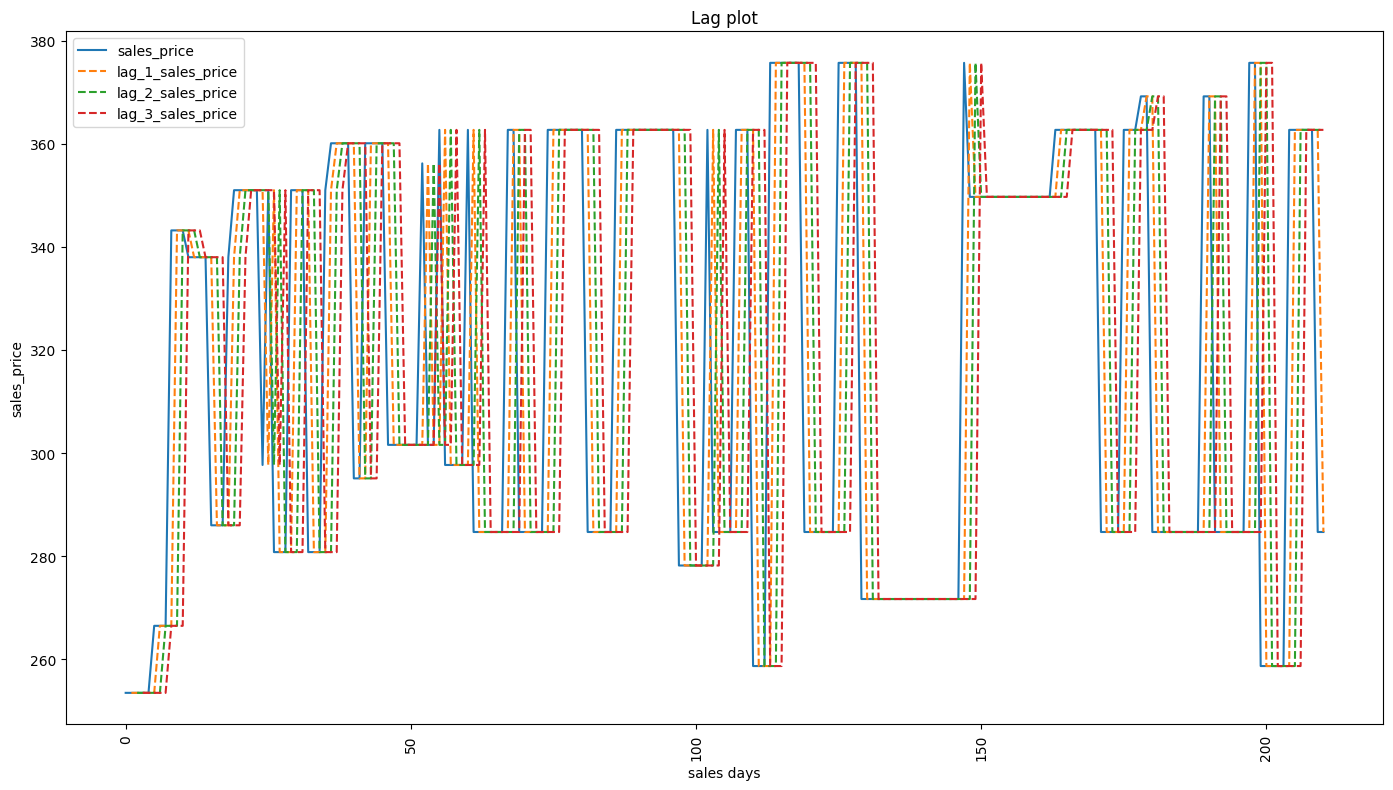

In [81]:
# let's ensure that lags are correctly calculated

plt.figure(figsize=(17, 9))
tsample = lagged_data.filter(pl.col('sku_id') == 1045).sort(by='date')
plt.plot(tsample['sales_price'], label='sales_price')
plt.plot(tsample['lag_1_sales_price'], '--', label='lag_1_sales_price')
plt.plot(tsample['lag_2_sales_price'], '--', label='lag_2_sales_price')
plt.plot(tsample['lag_3_sales_price'], '--', label='lag_3_sales_price')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('sales days')
plt.ylabel('sales_price')
plt.title('Lag plot')
plt.show()

#### Now let's add moving average for data within category

P.S.: it is also possible to add SMA and other similar indicators over sku_id, but it is out of scope of this research

Also important consideration is that data is not consistent

In [82]:
categories_agg = lagged_data.group_by(['category_id', 'date']).agg(
    pl.col('sales_price').mean(),
    pl.col('sales_quantity').sum()
).sort(by=['category_id', 'date'])
categories_agg

category_id,date,sales_price,sales_quantity
i64,date,f64,f64
7,2016-11-18,261.346,45.0
7,2016-11-19,276.706333,80.0
7,2016-11-20,215.148375,25.0
7,2016-11-21,185.4736,24.0
7,2016-11-22,199.96756,37.0
…,…,…,…
23,2020-10-27,40.1232,246.0
23,2020-10-28,38.058,215.0
23,2020-10-29,39.597,219.0


In [83]:
# manualy validate the results
lagged_data.filter(
    pl.col('category_id') == 7,
    pl.col('date') == pl.date(2016,11,18),
)['sales_quantity'].sum()

45.0

In [84]:
# we can see that still some sales data is missing for some dates
categories_agg.group_by('category_id').agg(
    ((pl.col('date').max() - pl.col('date').min()).dt.total_days() + 1).alias('required_dates_count'),
    pl.col('date').n_unique().alias('actual_unique_dates_count')
)

category_id,required_dates_count,actual_unique_dates_count
i64,i64,u32
7,1444,1419
17,1444,1420
23,1444,1420


In [85]:
WINDOW = 5

sma_aggregation = categories_agg.group_by(['category_id'], maintain_order=True).agg(
    pl.col('date'),
    pl.col('sales_price').rolling_mean(window_size=WINDOW),
    pl.col('sales_quantity').rolling_mean(window_size=WINDOW)
)
sma_aggregation

category_id,date,sales_price,sales_quantity
i64,list[date],list[f64],list[f64]
7,"[2016-11-18, 2016-11-19, … 2020-10-31]","[null, null, … 365.719506]","[null, null, … 147.4]"
17,"[2016-11-18, 2016-11-19, … 2020-10-31]","[null, null, … 69.107873]","[null, null, … 613.4]"
23,"[2016-11-18, 2016-11-19, … 2020-10-31]","[null, null, … 40.23932]","[null, null, … 254.8]"


In [86]:
sma_merged = []
for category, date, sale_price, sales_quantity in sma_aggregation.iter_rows():
    sma_merged.append(
        pl.DataFrame(
            schema=['date', f'sma_{WINDOW}_sales_price', f'sma_{WINDOW}_sales_quantity'],
            data=[date, sale_price, sales_quantity], orient='col'
        ).with_columns(pl.lit(category).cast(pl.Int64).alias('category_id'))
    )

sma_merged = pl.concat(sma_merged, how='vertical')
sma_merged

date,sma_5_sales_price,sma_5_sales_quantity,category_id
date,f64,f64,i64
2016-11-18,null,null,7
2016-11-19,null,null,7
2016-11-20,null,null,7
2016-11-21,null,null,7
2016-11-22,227.728374,42.2,7
…,…,…,…
2020-10-27,39.923755,258.6,23
2020-10-28,39.673649,250.8,23
2020-10-29,39.714009,239.0,23


In [87]:
feature_dataset = lagged_data.join(sma_merged, on=['category_id', 'date'],)
feature_dataset

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity,sma_5_sales_price,sma_5_sales_quantity
date,i64,i64,f64,f64,i32,i8,i8,i8,bool,f64,f64,f64,f64,f64,f64,f64,f64
2016-12-13,7,1045,253.5,1.0,2016,12,13,2,false,null,null,null,null,null,null,283.081244,44.4
2016-12-14,7,1045,253.5,1.0,2016,12,14,3,false,253.5,null,null,1.0,null,null,274.721276,42.0
2016-12-17,7,1045,253.5,1.0,2016,12,17,6,false,253.5,253.5,null,1.0,1.0,null,256.039892,46.2
2016-12-19,7,1045,253.5,2.0,2016,12,19,1,false,253.5,253.5,253.5,1.0,1.0,1.0,263.967558,50.6
2016-12-21,7,1045,253.5,1.0,2016,12,21,3,false,253.5,253.5,253.5,2.0,1.0,1.0,268.775519,54.4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2020-10-24,17,836236,63.7,2.0,2020,10,24,6,false,63.7,63.7,63.7,1.0,1.0,3.0,68.852398,667.8
2020-10-27,17,836236,63.7,1.0,2020,10,27,2,false,63.7,63.7,63.7,2.0,1.0,1.0,68.882609,617.8
2020-10-28,17,836236,63.7,1.0,2020,10,28,3,false,63.7,63.7,63.7,1.0,2.0,1.0,68.981406,578.6


In [88]:
feature_dataset.select(
    pl.col(col).is_null().sum().alias(f'{col}_nan_count')
    for col in feature_dataset.columns
)

date_nan_count,category_id_nan_count,sku_id_nan_count,sales_price_nan_count,sales_quantity_nan_count,year_nan_count,month_nan_count,day_nan_count,weekday_nan_count,is_ukrainian_holiday_nan_count,lag_1_sales_price_nan_count,lag_2_sales_price_nan_count,lag_3_sales_price_nan_count,lag_1_sales_quantity_nan_count,lag_2_sales_quantity_nan_count,lag_3_sales_quantity_nan_count,sma_5_sales_price_nan_count,sma_5_sales_quantity_nan_count
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,1059,2095,3109,1059,2095,3109,443,443


In [89]:
# let's validate that it joined correctly
sma_merged.filter(
    pl.col('sma_5_sales_price').is_null()
)['date'].unique()

date
date
2016-11-18
2016-11-19
2016-11-20
2016-11-21


In [90]:
# nulls are the same, so join was correct
lagged_data.filter(
    pl.col('date').is_between(pl.date(2016,11,18),	pl.date(2016,11,21))
)

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity
date,i64,i64,f64,f64,i32,i8,i8,i8,bool,f64,f64,f64,f64,f64,f64
2016-11-18,7,1428,717.6,1.0,2016,11,18,5,false,null,null,null,null,null,null
2016-11-18,7,2999,470.6,1.0,2016,11,18,5,false,null,null,null,null,null,null
2016-11-18,7,3923,383.5,1.0,2016,11,18,5,false,null,null,null,null,null,null
2016-11-18,17,8075,18.85,2.0,2016,11,18,5,false,null,null,null,null,null,null
2016-11-19,17,8075,18.85,5.0,2016,11,19,6,false,18.85,null,null,2.0,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-11-19,17,689959,24.57,5.0,2016,11,19,6,false,24.57,null,null,5.0,null,null
2016-11-20,17,689959,24.57,4.0,2016,11,20,7,false,24.57,24.57,null,5.0,5.0,null
2016-11-21,17,689959,24.57,2.0,2016,11,21,1,false,24.57,24.57,24.57,4.0,5.0,5.0


### Clustering

Let's perform clustering. Maybe it will help to predict sale_quantity better

In [92]:
clean_dataset = feature_dataset.drop_nulls()
clean_dataset

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity,sma_5_sales_price,sma_5_sales_quantity
date,i64,i64,f64,f64,i32,i8,i8,i8,bool,f64,f64,f64,f64,f64,f64,f64,f64
2016-12-19,7,1045,253.5,2.0,2016,12,19,1,false,253.5,253.5,253.5,1.0,1.0,1.0,263.967558,50.6
2016-12-21,7,1045,253.5,1.0,2016,12,21,3,false,253.5,253.5,253.5,2.0,1.0,1.0,268.775519,54.4
2016-12-31,7,1045,266.5,2.0,2016,12,31,6,false,253.5,253.5,253.5,1.0,2.0,1.0,283.294273,189.0
2017-01-03,7,1045,266.5,1.0,2017,1,3,2,false,266.5,253.5,253.5,2.0,1.0,2.0,264.30989,157.2
2017-01-04,7,1045,266.5,1.0,2017,1,4,3,false,266.5,266.5,253.5,1.0,2.0,1.0,261.494658,125.4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2020-10-23,17,836236,63.7,1.0,2020,10,23,5,false,63.7,63.7,63.7,1.0,3.0,1.0,68.889004,647.0
2020-10-24,17,836236,63.7,2.0,2020,10,24,6,false,63.7,63.7,63.7,1.0,1.0,3.0,68.852398,667.8
2020-10-27,17,836236,63.7,1.0,2020,10,27,2,false,63.7,63.7,63.7,2.0,1.0,1.0,68.882609,617.8


In [93]:
# normalize dataset due to K-Means is affected by feature scale
features = clean_dataset.to_numpy()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

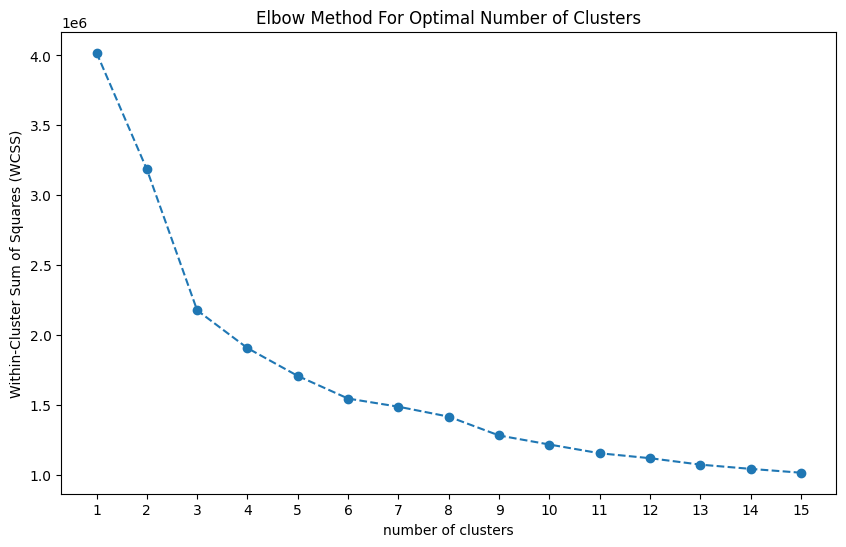

In [94]:
wcss = []
max_clusters = 15
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_clusters + 1))
plt.show()

The optimal number for clusters is from 3 to 5

In [95]:
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE)
kmeans = kmeans.fit(features_scaled)

In [96]:
clusters = kmeans.fit_predict(features_scaled)

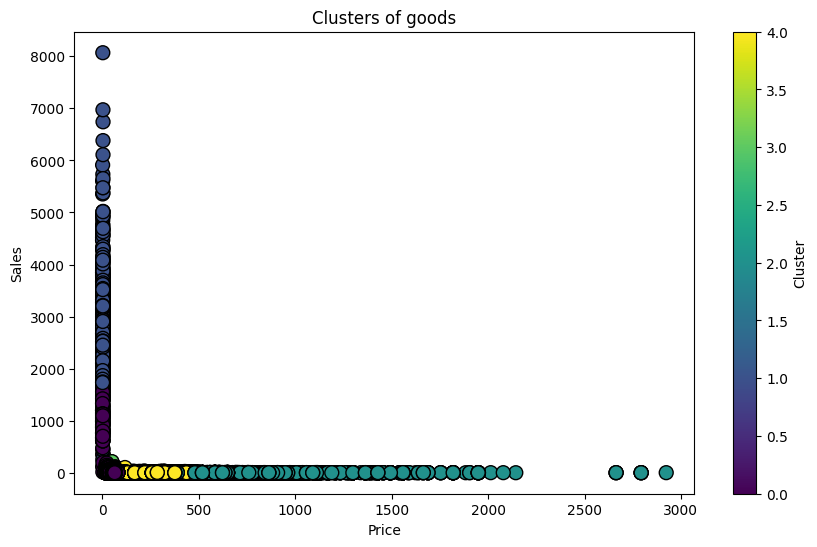

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(
    clean_dataset['sales_price'], 
    clean_dataset['sales_quantity'], 
    c=clusters, 
    cmap='viridis', 
    marker='o',
    edgecolor='k', 
    s=100
)
plt.title('Clusters of goods')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.colorbar(label='Cluster')
plt.show()

- I sticked to 5 clusters, which can be interpreted as following:
    - **blue**: goods with low prices and high sales (general goods)
    - **purple**: goods with optimal prices and low sales (budget goods)
    - **light green**: goods with *lowest* prices and *lowest* sales, possibly bad-quality goods
    - **yellow**: goods with optimal prices and low sales (mid-price goods, goods not of the first importance)
    - **cyan**: goods with high prices and low sales (premium goods)
- We can use this clusters as a feature, or better to calculate aggregations within clusters
- TODO: use another clustering algorithm

For now, I will add cluster_id as feature to dataset, but in further analysis it would be better to add aggregations within calculated clusters

In [98]:
processed_dataset = clean_dataset.with_columns(
    pl.Series(values=clusters).alias('cluster_id')
)
processed_dataset

date,category_id,sku_id,sales_price,sales_quantity,year,month,day,weekday,is_ukrainian_holiday,lag_1_sales_price,lag_2_sales_price,lag_3_sales_price,lag_1_sales_quantity,lag_2_sales_quantity,lag_3_sales_quantity,sma_5_sales_price,sma_5_sales_quantity,cluster_id
date,i64,i64,f64,f64,i32,i8,i8,i8,bool,f64,f64,f64,f64,f64,f64,f64,f64,i32
2016-12-19,7,1045,253.5,2.0,2016,12,19,1,false,253.5,253.5,253.5,1.0,1.0,1.0,263.967558,50.6,4
2016-12-21,7,1045,253.5,1.0,2016,12,21,3,false,253.5,253.5,253.5,2.0,1.0,1.0,268.775519,54.4,4
2016-12-31,7,1045,266.5,2.0,2016,12,31,6,false,253.5,253.5,253.5,1.0,2.0,1.0,283.294273,189.0,4
2017-01-03,7,1045,266.5,1.0,2017,1,3,2,false,266.5,253.5,253.5,2.0,1.0,2.0,264.30989,157.2,4
2017-01-04,7,1045,266.5,1.0,2017,1,4,3,false,266.5,266.5,253.5,1.0,2.0,1.0,261.494658,125.4,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2020-10-23,17,836236,63.7,1.0,2020,10,23,5,false,63.7,63.7,63.7,1.0,3.0,1.0,68.889004,647.0,0
2020-10-24,17,836236,63.7,2.0,2020,10,24,6,false,63.7,63.7,63.7,1.0,1.0,3.0,68.852398,667.8,0
2020-10-27,17,836236,63.7,1.0,2020,10,27,2,false,63.7,63.7,63.7,2.0,1.0,1.0,68.882609,617.8,0


### Feature importance

For now we will train simple RandomForestRegressor on all train data to see feature importance

In [99]:
processed_dataset = processed_dataset.sample(fraction=1, shuffle=True)

In [100]:
X, y = processed_dataset.drop('date', 'sales_quantity'), processed_dataset['sales_quantity']

In [101]:
model = RandomForestRegressor(n_jobs=-1)
model = model.fit(X, y)

In [102]:
imp_df = pl.DataFrame({
    'feature': model.feature_names_in_,
    'importance': model.feature_importances_
}).sort(by='importance', descending=True)

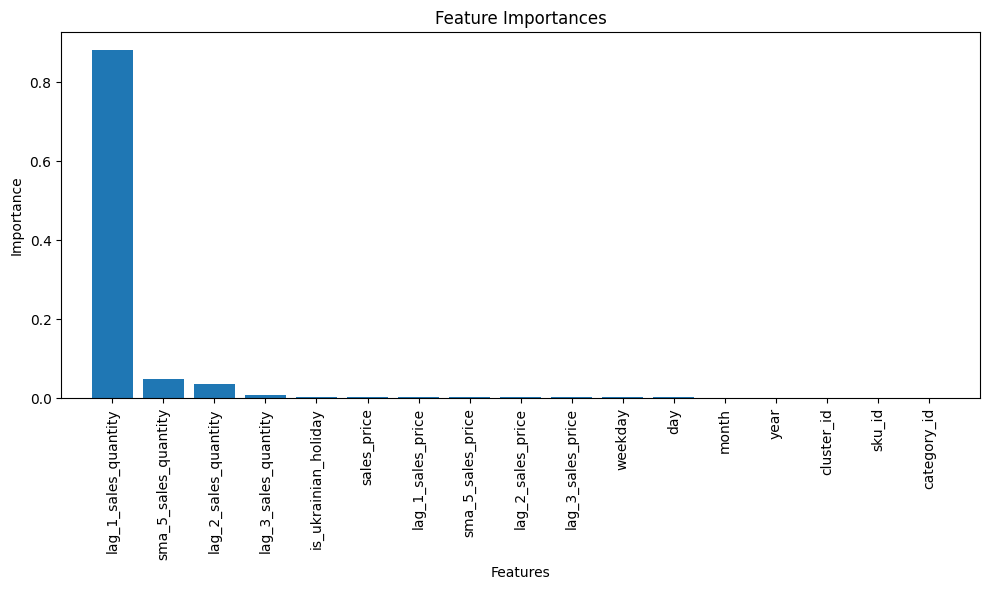

In [103]:
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), imp_df['importance'], align='center')
plt.xticks(range(X.shape[1]), imp_df['feature'], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

- We can see, that the best features are lag-aggregations, calculated within sku_id, which is quite obvious. Because there definetely is correlation in quantity between last and next sales days.
- However, further checks need to be made and verified, that there is no data leakage.

- TODO: Also try to use more complex method to calculate feature importance (i.e. one-out feature, etc.)

### Example model training 

- Firstly, we need to define metrics to evaluate our models. 
- Since it is regression task, I will choose RMSE, MAE and explained_variance metrics (these are the most suitable for this task). 
- Also it is important to mention that i will choose only RandomForest and LightGBM models to perform regression.
- It is possible to train several mini-models within category or cluster_id for better results.

In [104]:
# Firstly, let's try simple RandomForest for a baseline model
# I will use cross validation to achive more stable scores
model = RandomForestRegressor()
results = cross_validate(model, X, y, cv=3, n_jobs=-1, scoring=[
    'neg_root_mean_squared_error', 
    'neg_mean_absolute_error',
    'explained_variance'
])

In [105]:
pl.DataFrame(results)

fit_time,score_time,test_neg_root_mean_squared_error,test_neg_mean_absolute_error,test_explained_variance
f64,f64,f64,f64,f64
103.181423,1.889061,-37.350705,-4.058365,0.962947
103.094209,1.999809,-31.842279,-3.669883,0.967202
103.708831,1.981444,-34.996693,-3.754887,0.964386


- So, results are already quite good (the model predicts with +- 4 quantity points accuracy)
- I will try LGBM model with hyperparameter optimization framework "optuna".
- Scripts for training, evaluation and inference are available under src folder and results.ipynb notebook